In [135]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
import scipy
from sklearn.preprocessing import scale
from scipy.cluster import hierarchy
from scipy.stats import skew  
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

import xgboost
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.kernel_ridge import KernelRidge

np.random.seed(7)

In [177]:
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')

# Recommended by the creator of the dataset.
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Save ID
train_ID = train['Id']
test_ID = test['Id']

X_train = train.drop(['Id','SalePrice'], axis = 1)
y_train = train.SalePrice

test = test.drop('Id',axis = 1)

## Feature engineering

In [178]:
def split(X_train,y_train): # split function

    X_train, X_test, y_train, y_test  = train_test_split(X_train,y_train)
    
    return X_train, X_test, y_train, y_test

### Missing values

The documentation mentioned that we had missing values, let's check them out. 

In [179]:
missing = X_train.isnull().sum() / len(X_train) # Let's get the missing values percentage for each column.
missing = missing.sort_values(ascending=False).to_frame('Missing percentage').reset_index() # Lets sort it.

In [180]:
missing.head(5) # Now let's see the 5 columns with more missing values.

,index,Missing percentage
0,PoolQC,0.995885
1,MiscFeature,0.962963
2,Alley,0.937586
3,Fence,0.807270
4,FireplaceQu,0.473251


We can see that we have some features with a lot of missing values, such as Pool, Misc Feature and Alley. We could drop them.   
However, the documentation states that no value means that there is no pool or misc feature or alley. So despite it being a small amount of information, it could still be valuable.

### Dependent variable

First, let's see our original column, saleprice. 

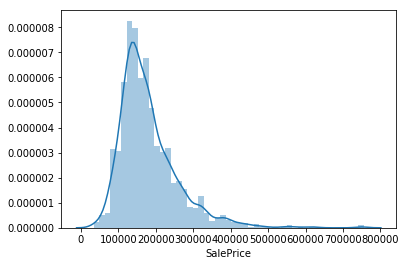

In [181]:
sns.distplot(y_train)
plt.show()

We can see that our data looks like a normal with a right skew.  In order to correct this, we will transform our values from SalePrice

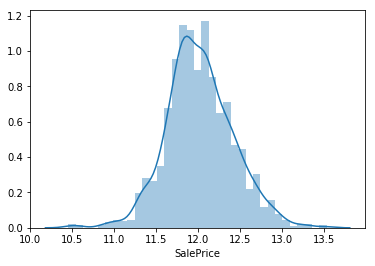

In [182]:
# np.log1p does log(1+x) to the SalePrice
y_train = np.log1p(y_train)
# Lets see how it looks
sns.distplot(y_train);
plt.show()

### Correlations

Let's see how our variables correlate with the dependent variable.

In [183]:
corrmat = X_train.corr()
# Lets order the correlation matrix in order for it to be more readable
order = np.array(hierarchy.dendrogram(
    hierarchy.ward(corrmat),no_plot=True)['ivl'], dtype="int")

In [184]:
corrmat_ordered = corrmat.iloc[order,order]

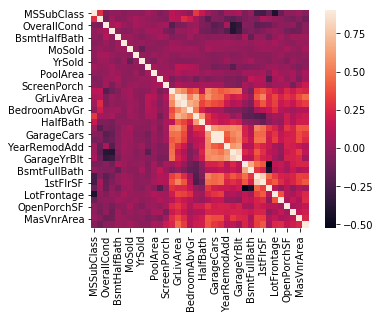

In [185]:
sns.heatmap(corrmat_ordered, vmax=0.9, square=True)
plt.show()

Now that we have a better idea of the data, we can do the feature engineering (visualizations.ipynb)

In [205]:
def feature_eng(X_train, y_train, test):

    data = pd.concat([X_train,test]).reset_index(drop=True)

    ### Data imputation ###

    # First, there are features that are considered numerical when they are not. We have to change this
    to_str = ['MSSubClass','YrSold','MoSold']
    for col in to_str: data[col] = data[col].apply(str)

    #  Let's get the mode for each of these values as imputation
    to_mode = ['Functional','Electrical','KitchenQual','Exterior1st','Exterior2nd','SaleType']
    for col in to_mode: data[col] = data[col].fillna(data[col].mode()[0])


    # For MSZoning and LotFrontage, it seems a popular choice for other competitors to group by neighborhood and then take mode or median, so we will do the same.
    data['MSZoning'] = data.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    data['LotFrontage'] = data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    #  Now, for some of our valuables, Nan actually means none or cero, depending on the case. We should change this.
    # This is actually the case for all the variables that we have left.

    # None
    for col in data.columns:
        if data[col].dtype == object: data[col] = data[col].fillna('None')
    
    # Cero
    for col in data.columns:
        if data[col].dtype != object: 
            data[col] = data[col].fillna(0)

    ### Box Cox ###  This idea/code comes from: https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models

    # Now that our data is complete, we will do box cox transformation for skewed data. Everything with a skew above 0.5 is skewed. 
    # First, let's get numerical columns.
    numerical = [col for col in data.columns if data[col].dtype != object]

    # Now we calculate the skew. 
    skew_data = data[numerical].apply(lambda x: skew(x)).sort_values(ascending=False)

    # Whatever is higher than 0.5, we will apply the box cox transformation
    high_skew = skew_data[skew_data > 0.5]
    skew_index = high_skew.index

    for i in skew_index:
        data[i] = boxcox1p(data[i], boxcox_normmax(data[i] + 1))

    ### Obtaining additional features ###

    # This part is quite intuitive, but i did not think of it until I saw it.
    # The idea/code came from Alex Lekov: https://www.kaggle.com/itslek/blend-stack-lr-gb-0-10649-house-prices-v57
  
    data['YrBltAndRemod']=data['YearBuilt']+data['YearRemodAdd']
    data['TotalSF']=data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']

    data['Total_sqr_footage'] = (data['BsmtFinSF1'] + data['BsmtFinSF2'] +
                                     data['1stFlrSF'] + data['2ndFlrSF'])

    data['Total_Bathrooms'] = (data['FullBath'] + (0.5 * data['HalfBath']) +
                                   data['BsmtFullBath'] + (0.5 * data['BsmtHalfBath']))

    data['Total_porch_sf'] = (data['OpenPorchSF'] + data['3SsnPorch'] +
                                  data['EnclosedPorch'] + data['ScreenPorch'] +
                                  data['WoodDeckSF'])

    # Simplified data, if it has it or not. 
    data['Pool'] = data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    data['2ndfloor'] = data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    data['Garage'] = data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    data['Basement'] = data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    data['Fireplace'] = data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

    data = data.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

    ### Spliting back our data ###
    
    # final_data = pd.get_dummies(data).reset_index(drop=True)

    X_train = data.iloc[:len(y_train), :]
    test = data.iloc[len(X_train):, :]

    return X_train, test

In [187]:
X_train, test = feature_eng(X_train,y_train,test)

In [188]:
def check_missing(df,val): 
    missing = df.isnull().sum() / len(df) # Let's get the missing values percentage for each column.
    missing = missing.sort_values(ascending=False).to_frame('Missing percentage').reset_index() # Lets sort it.
    remaining = missing[missing['Missing percentage'] > val]['index'].values
    return remaining

In [189]:
check_missing(X_train,0) # Now let's see if there are things that are left.

array([], dtype=object)

In [190]:
check_missing(test,0)

array([], dtype=object)

Now that we know what our dataframe features are, and we have done some feature selection, we are going to start trying to predict.

## Baseline

Let's create a baseline for prediction. We will create a couple linear regresions and see what parameters are optimal. Once this is done, we will try to obtain a prediction and see how we did. 

In [191]:
def regression_w_GS(X_train,y_train):

    categorical = X_train.dtypes == object
    X_train, X_test, y_train, y_test = split(X_train,y_train)

    # Lets do the column transformer with Standar Scaler and One-Hot Encoder.
    preprocess = make_column_transformer(
        (RobustScaler(), ~categorical),
        (OneHotEncoder(handle_unknown = 'ignore'), categorical))

    model_LR = make_pipeline(preprocess, LinearRegression())
    model_R = make_pipeline(preprocess, Ridge())
    model_L = make_pipeline(preprocess, Lasso())
    model_EN = make_pipeline(preprocess, ElasticNet())
    model_KR = make_pipeline(preprocess,  KernelRidge())

    # Linear Regression.

    param_grid_LR = {'linearregression__fit_intercept': (True,False),
                  'linearregression__normalize': (True,False)}

    grid_LR = GridSearchCV(model_LR,param_grid_LR,scoring="neg_mean_squared_error", cv=5, n_jobs = -1)
    
    #return X_train, y_train
    
    grid_LR.fit(X_train, y_train)

    print('\t\t\t Linear Regression: \n')
    print(grid_LR.best_params_, '\t score: ',np.sqrt(-grid_LR.score(X_test, y_test)),'\n')

    # Ridge.

    param_grid_R = {'ridge__alpha':np.logspace(-3, 3, num=13)} # we will check alphas between 0.001 and 100

    grid_R = GridSearchCV(model_R,param_grid_R,scoring="neg_mean_squared_error", cv=3, n_jobs = -1)
    grid_R.fit(X_train, y_train)

    print('\t\t\t Ridge: \n')
    print(grid_R.best_params_, '\t score: ',np.sqrt(-grid_R.score(X_test, y_test)),'\n')

    # Lasso.

    param_grid_L = {'lasso__alpha':np.logspace(-3, 3, num=13)} # we will check alphas between 0.001 and 100

    grid_L = GridSearchCV(model_L,param_grid_L,scoring="neg_mean_squared_error", cv=3, n_jobs = -1)
    grid_L.fit(X_train, y_train)

    print('\t\t\t Lasso: \n')
    print(grid_L.best_params_, '\t score: ',np.sqrt(-grid_L.score(X_test, y_test)),'\n')

    # ElasticNet.

    param_grid_EN = {'elasticnet__alpha':np.logspace(-4, 0, 13)}

    grid_EN = GridSearchCV(model_EN,param_grid_EN,scoring="neg_mean_squared_error", cv=3, n_jobs = -1)
    grid_EN.fit(X_train, y_train)

    print('\t\t\t ElasticNet: \n')
    print(grid_EN.best_params_, '\t score: ',np.sqrt(-grid_EN.score(X_test, y_test)),'\n')
    
    # Kernel Ridge


    param_grid_KR = {'kernelridge__alpha':np.logspace(-3, 3, num=13)} # we will check alphas between 0.001 and 100

    grid_KR = GridSearchCV(model_KR,param_grid_KR,scoring="neg_mean_squared_error", cv=3, n_jobs = -1)
    grid_KR.fit(X_train, y_train)

    print('\t\t\t Kernel Ridge: \n')
    print(grid_KR.best_params_, '\t score: ',np.sqrt(-grid_KR.score(X_test, y_test)),'\n')


    

In [192]:
# Let's get the best alpha for ridge and lasso
regression_w_GS(X_train,y_train)

			 Linear Regression: 

{'linearregression__fit_intercept': True, 'linearregression__normalize': True} 	 score:  0.15229931121318113 

			 Ridge: 

{'ridge__alpha': 10.0} 	 score:  0.11811815803767095 

			 Lasso: 

{'lasso__alpha': 0.001} 	 score:  0.11794766191146833 

			 ElasticNet: 

{'elasticnet__alpha': 0.001} 	 score:  0.1164082399796989 

			 Kernel Ridge: 

{'kernelridge__alpha': 0.31622776601683794} 	 score:  0.12946277871368242 



In [193]:
def regressions(X_train,y_train):
    
    categorical = X_train.dtypes == object
    
    # Lets do the column transformer with Standar Scaler and One-Hot Encoder.
    preprocess = make_column_transformer(
        (RobustScaler(), ~categorical),
        (OneHotEncoder(handle_unknown = 'ignore'), categorical))

    model_R = make_pipeline(preprocess, Ridge(alpha = 10))
    model_L = make_pipeline(preprocess, Lasso(alpha = 1e-3))
    model_EN = make_pipeline(preprocess, ElasticNet(alpha = 1e-3))
    # We will use cross validation to avoid overfitting.
    
    
    print('Ridge score is: ' , np.sqrt(-np.mean(cross_val_score(model_R,X_train,y_train,scoring="neg_mean_squared_error", cv = 10,n_jobs = -1))),'\n')
    print('Lasso score is: ' , np.sqrt(-np.mean(cross_val_score(model_L,X_train,y_train,scoring="neg_mean_squared_error", cv = 10,n_jobs = -1))),'\n')
    print('Elastic Net score is: ' , np.sqrt(-np.mean(cross_val_score(model_EN,X_train,y_train,scoring="neg_mean_squared_error", cv = 10,n_jobs = -1))),'\n')
    
    return model_EN, model_R, model_L

In [194]:
model_EN,model_R,model_L = regressions(X_train,y_train) # Now let's get our models with said hyperparameters.

Ridge score is:  0.10995425493904373 

Lasso score is:  0.10944181734382376 


 Elastic Net score is:  0.10768692235446294 



## Modelling

The RMSE and R squared are pretty descent right now. However, now that we know the prediction, I would like to go a step further and implement more robust algorithms and see if we can improve this score. The algorithms that we are going to use are:   

* Random Forests
* Gradient boosting
* Light GBM

and the model to beat is the linear regression.

In [195]:
def boosting_models(X_train,y_train):
    
    categorical = X_train.dtypes == object

    # Lets do the column transformer with Standar Scaler and One-Hot Encoder.
    preprocess = make_column_transformer(
        (RobustScaler(), ~categorical),
        (OneHotEncoder(handle_unknown = 'ignore'), categorical))
    
    model_GBC = make_pipeline(
        preprocess,  GradientBoostingRegressor(alpha = 0.85,n_estimators = 1000,max_depth = 3, max_features = 70))
    model_LGB = make_pipeline(
        preprocess, LGBMRegressor(objective='regression',num_leaves=5,  
                              learning_rate=0.05, n_estimators=800))
    model_XGB = make_pipeline(
        preprocess, xgboost.XGBRegressor(gamma=0.05,learning_rate=0.05, max_depth=3,
                                         n_estimators=2500,reg_alpha=0.5, reg_lambda=0.85))

    print('Gradient Boosting score is: ' ,
          np.sqrt(-np.mean(cross_val_score(model_GBC,X_train,y_train, scoring="neg_mean_squared_error", cv = 10, n_jobs = -1))),'\n')
    print('Light Gradient Boosting score is: ' ,
          np.sqrt(-np.mean(cross_val_score(model_LGB,X_train,y_train, scoring="neg_mean_squared_error", cv = 10, n_jobs = -1))),'\n')
    print(' Extreme Gradient Boosting score is: ' ,
          np.sqrt(-np.mean(cross_val_score(model_XGB,X_train,y_train, scoring="neg_mean_squared_error", cv = 5, n_jobs = -1))),'\n')
    
    
    return model_GBC, model_LGB,model_XGB

In [196]:
model_GBC, model_LGB, model_XGB = boosting_models(X_train,y_train)

Gradient Boosting score is:  0.11704551425854046 

Light Gradient Boosting score is:  0.11917911589977526 

 Extreme Gradient Boosting score is:  0.12349283203432586 



### Stacking Regressor

In [197]:
def stacking_model(X_train,y_train):
    
    
    lasso = Lasso(alpha = 1e-3)
    GBC = GradientBoostingRegressor(alpha = 0.85,n_estimators = 1000,max_depth = 3, max_features = 70)
    LGB = LGBMRegressor(objective='regression',num_leaves=5,  
                        learning_rate=0.05, n_estimators=800)
    XGB = xgboost.XGBRegressor(gamma=0.05,learning_rate=0.05, max_depth=3,
                               n_estimators=2500,reg_alpha=0.5, reg_lambda=0.85)
    
    
    categorical = X_train.dtypes == object

    # Lets do the column transformer with Standar Scaler and One-Hot Encoder.
    preprocess = make_column_transformer(
        (RobustScaler(), ~categorical),
        (OneHotEncoder(handle_unknown = 'ignore'), categorical))

    model_SR = make_pipeline(preprocess,
                             StackingRegressor(regressors=[GBC,LGB,XGB],
                                               meta_regressor=lasso))

    scores = cross_val_score(model_SR, X_train, y_train, scoring='neg_mean_squared_error',cv=5, n_jobs = -1)

    print("Stacking Regressor score ", (np.sqrt(-scores.mean()), scores.std()))
    
    return model_SR

In [198]:
model_SR = stacking_model(X_train,y_train)

Stacking Regressor score  (0.11813620408082884, 0.001961416769287875)


### Solutions

In [199]:
def toKaggle(test_ID,pred):

    resp= test_ID.to_frame('Id')
    resp['SalePrice'] = pred
    
    return resp

In [200]:
model_GBC.fit(X_train,y_train)
model_XGB.fit(X_train,y_train)
model_LGB.fit(X_train,y_train)
model_R.fit(X_train,y_train)
model_SR.fit(X_train,y_train)
model_EN.fit(X_train,y_train)
model_L.fit(X_train,y_train)

pred_en = np.expm1(model_EN.predict(test))
pred_l = np.expm1(model_L.predict(test))
pred_gbc = np.expm1(model_GBC.predict(test))
pred_lgbm =np.expm1(model_LGB.predict(test))
pred_xgb = np.expm1(model_XGB.predict(test))
pred_r = np.expm1(model_R.predict(test))
pred_sr = np.expm1(model_SR.predict(test))

In [201]:
pred = np.floor((pred_sr + pred_lgbm + pred_xgb + pred_r+pred_gbc+pred_en+pred_l)/7)

In [202]:
resp = toKaggle(test_ID,pred)

In [203]:
resp.head(5)

,Id,SalePrice
0,1461,123517.0
1,1462,158457.0
2,1463,185745.0
3,1464,197343.0
4,1465,187986.0


In [204]:
resp.to_csv('submission.csv',index = False)